In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
import pickle
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
dataset = load_dataset("ThuraAung1601/myanmar_news")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

In [120]:
with open("save/mapped_vectors.pkl", "rb") as f:
    mapped_vectors = pickle.load(f)

print(f"Total mapped vectors: {len(mapped_vectors)}")
example_key = list(mapped_vectors.keys())[0]
print("Example:", example_key, mapped_vectors[example_key][:10])


Total mapped vectors: 76700
Example: ပထမအင်္ဂလိပ်အက္ခရာ [-0.03610078 -0.02706265 -0.02505255 -0.03319115 -0.02951134 -0.02600441
 -0.02033756 -0.039611   -0.03369364 -0.02263284]


In [ ]:
# model = torch.load("save/daeme_model.pth", map_location=device, weights_only=False)
# model.to(device)
# model.eval()


DAEME(
  (encoder_burmese): Linear(in_features=300, out_features=300, bias=True)
  (encoder_english): Linear(in_features=300, out_features=300, bias=True)
  (decoder_burmese): Linear(in_features=300, out_features=300, bias=True)
  (decoder_english): Linear(in_features=300, out_features=300, bias=True)
  (activation): ReLU()
)

In [121]:
def texts_to_vectors(texts, vec_dict):
    vec = []
    for t in texts:
        if t in vec_dict:
            vec.append(vec_dict[t])
        else:
            vec.append(np.random.normal(0, 0.01, 300))
    return F.normalize(torch.tensor(vec, dtype=torch.float32), p=2, dim=1).to(device)


In [122]:
all_vecs = torch.tensor(list(mapped_vectors.values()))
print("Mean:", all_vecs.mean().item())
print("Std:", all_vecs.std().item())


Mean: -0.04369891807436943
Std: 0.05215756595134735


In [123]:
label_encoder = LabelEncoder()
train_labels = list(train_labels)
test_labels = list(test_labels)
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)

In [124]:
X_train = texts_to_vectors(train_texts, mapped_vectors)
X_test = texts_to_vectors(test_texts, mapped_vectors)
y_train = torch.tensor(train_encoded, dtype=torch.long).to(device)
y_test = torch.tensor(test_encoded, dtype=torch.long).to(device)

print("Train tensor shape:", X_train.shape)
print("Test tensor shape:", X_test.shape)

Train tensor shape: torch.Size([5844, 300])
Test tensor shape: torch.Size([1471, 300])


In [125]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [126]:
print(len(train_texts), X_train.shape[0], y_train.shape[0])


5844 5844 5844


In [128]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=300, hidden_dim1=512, hidden_dim2=256, num_classes=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)


In [129]:
model = MLPClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001) 
epochs = 100
batch_size = 64

In [130]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.8775
Epoch 2, Loss: 1.8447
Epoch 3, Loss: 1.8101
Epoch 4, Loss: 1.7897
Epoch 5, Loss: 1.7697
Epoch 6, Loss: 1.7476
Epoch 7, Loss: 1.7361
Epoch 8, Loss: 1.7171
Epoch 9, Loss: 1.6943
Epoch 10, Loss: 1.6695
Epoch 11, Loss: 1.6584
Epoch 12, Loss: 1.6408
Epoch 13, Loss: 1.6156
Epoch 14, Loss: 1.6047
Epoch 15, Loss: 1.5692
Epoch 16, Loss: 1.5530
Epoch 17, Loss: 1.5295
Epoch 18, Loss: 1.5153
Epoch 19, Loss: 1.4914
Epoch 20, Loss: 1.4836
Epoch 21, Loss: 1.4540
Epoch 22, Loss: 1.4378
Epoch 23, Loss: 1.4059
Epoch 24, Loss: 1.3887
Epoch 25, Loss: 1.3573
Epoch 26, Loss: 1.3473
Epoch 27, Loss: 1.3073
Epoch 28, Loss: 1.2905
Epoch 29, Loss: 1.2709
Epoch 30, Loss: 1.2299
Epoch 31, Loss: 1.2065
Epoch 32, Loss: 1.1836
Epoch 33, Loss: 1.1631
Epoch 34, Loss: 1.1335
Epoch 35, Loss: 1.1088
Epoch 36, Loss: 1.0712
Epoch 37, Loss: 1.0504
Epoch 38, Loss: 1.0305
Epoch 39, Loss: 1.0075
Epoch 40, Loss: 0.9793
Epoch 41, Loss: 0.9642
Epoch 42, Loss: 0.9253
Epoch 43, Loss: 0.8924
Epoch 44, Loss: 0.87

In [131]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, preds = torch.max(outputs, 1)
    test_acc = (preds == y_test).sum().item() / y_test.size(0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.1693


In [132]:
from sklearn.metrics import classification_report

print(classification_report(y_test.cpu(), preds.cpu(), target_names=label_encoder.classes_))


                             precision    recall  f1-score   support

          __label__Business       0.17      0.18      0.18       265
     __label__Entertainment       0.17      0.16      0.17       241
       __label__Environment       0.18      0.16      0.17       228
          __label__Politics       0.17      0.20      0.18       245
__label__Science&Technology       0.16      0.16      0.16       239
            __label__Sports       0.17      0.15      0.16       253

                   accuracy                           0.17      1471
                  macro avg       0.17      0.17      0.17      1471
               weighted avg       0.17      0.17      0.17      1471



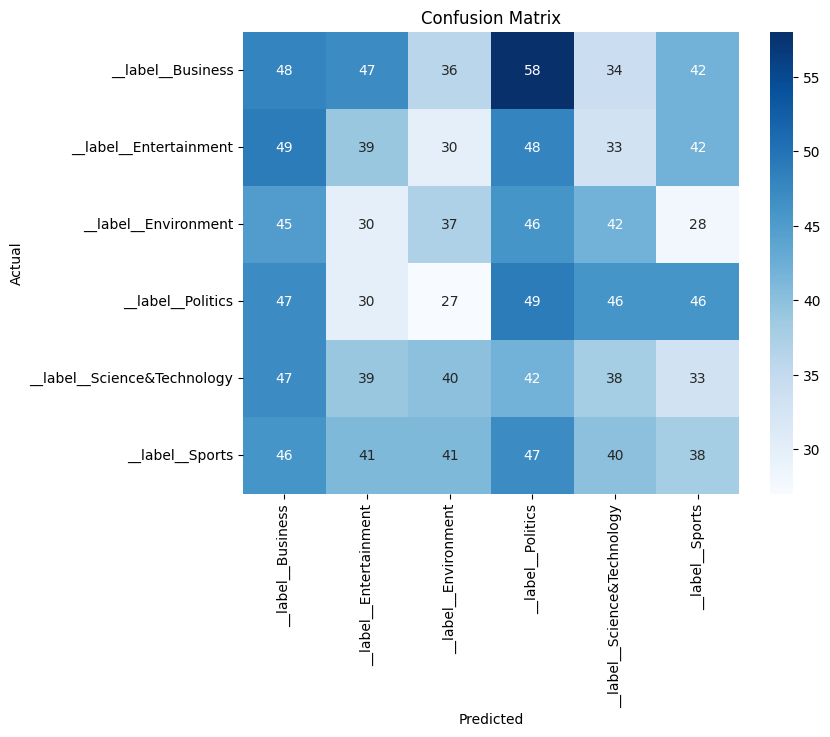

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.cpu(), preds.cpu())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

